In [261]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt

In [262]:
n_train = 50

In [263]:
x_train,_=torch.sort(torch.rand(n_train)*5)
def f(x):
    return 2*torch.sin(x)+x**0.8
y_train=f(x_train)+torch.normal(0,0.5,size=(n_train,))
x_test = torch.arange(0,5,0.1)
y_truth=f(x_test)
n_test=len(x_test)
n_test

50

In [264]:
##平均汇聚
y_hat=(y_train.mean()).repeat(y_train.shape[0])

In [265]:
# 非参数注意力汇聚  x_test是测试集服了 x_test 是query x_train是key y_train是value
# x_train.shape,x_test.shape,y_train.shape,y_test.shape 均为torch.Size([50]) n_train=n_test=50
x_repeat=x_test.repeat_interleave(50).reshape(50,-1)
softmax_r=nn.functional.softmax(-1/2*(x_train-x_repeat)**2,dim=1)
r=torch.matmul(softmax_r,y_train)


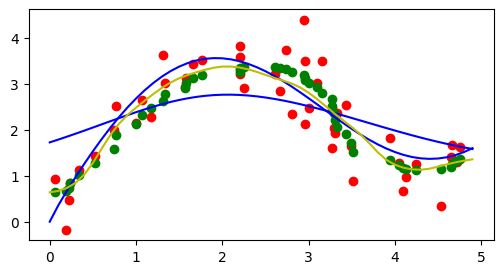

In [340]:
fig=plt.figure(figsize=(6,3))
plt.plot(x_test,y_truth,'b')
plt.scatter(x_train,y_train,c='r')
plt.scatter(x_train,y_hat,c='g')
plt.plot(x_test,r,c='b')

plt.plot(x_test,y_hat_para,c='y')

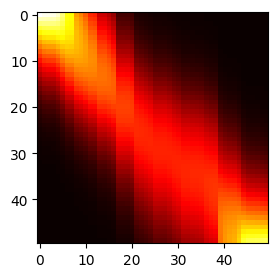

In [268]:
plt.figure(figsize=(6,3))
plt.imshow(softmax_r,cmap='hot')

# 带有参数的注意力汇聚

In [269]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape
# torch.bmm(input, mat2) 对输入的两个三维张量中的对应批次进行标准的矩阵乘法。
# 
# 如果 input 的形状是 (B, H, W)，而 mat2 的形状是 (B, W', H')：
# 
# torch.bmm 要求 B (批量大小) 必须相等。
# torch.bmm 要求 W (第一个张量的最后一维) 必须等于 W' (第二个张量的倒数第二维)。
# 何时可以用 matmul 替代 bmm？
# 当输入张量满足以下条件时，matmul 的行为与 bmm 完全等效：
# 
# 输入均为三维张量：
# input1.shape = (B, N, M)
# input2.shape = (B, M, P)

torch.Size([2, 1, 6])

In [283]:
weights = torch.ones((2, 10))*0.1

In [288]:
values = torch.arange(20.0).reshape((2, 10))

In [290]:
values.shape,weights.shape

(torch.Size([2, 10]), torch.Size([2, 10]))

In [302]:
# 以使用小批量矩阵乘法来计算小批量数据中的加权平均值 ,但是直接用对应元素乘法接上sum也可以,但是前者的维度是3
(weights.unsqueeze(1) @ values.unsqueeze(-1)).squeeze()==(weights*values).sum(dim=1)

tensor([True, True])

In [329]:
# 定义模型
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super(NWKernelRegression, self).__init__()
        ## nn.Parameter 的默认行为：在 PyTorch 中，nn.Parameter 是一个特殊的 Tensor 类型，用于表示模型的参数。它构造函数的 requires_grad 参数默认值为 True。这意味着，当你创建 nn.Parameter 时，除非显式指定 requires_grad=False，否则它总是会自动设置 requires_grad=True。
        self.attention_weights = None
        self.w=nn.Parameter(torch.randn((1,)))
        #query和 kyes 都是批量大小*元素个数的矩阵
    def forward(self, queries,keys,values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        ## 重复keys.shape[1]次是因为keys的每一行有n个值，作为要查询的keys 因此作为要去匹配的queries 重复n次以在运算的时候能够与每个keys进行匹配计算距离
        queries=queries.repeat_interleave(keys.shape[1]).reshape(-1,keys.shape[1])
        self.attention_weights = nn.functional.softmax(-((queries-keys) * self.w)**2 / 2, dim=1)
        return torch.bmm(self.attention_weights.unsqueeze(1),values.unsqueeze(-1)).reshape(-1)
    
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))


# 训练
net=NWKernelRegression()
loss=nn.MSELoss(reduction='none')
optimizer=torch.optim.Adam(net.parameters(), lr=0.5)
for epoch in range(10):
    optimizer.zero_grad()
    output=net(x_train,keys,values)
    l=loss(output,y_train)
    l.sum().backward()
    optimizer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')

In [338]:
## 做预测 就不要去剔除对角线了
keys=x_train.repeat(50,1)
values=y_train.repeat((n_test, 1))
y_hat_para = net(x_test, keys, values).detach().numpy()

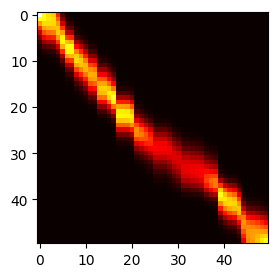

In [344]:
plt.figure(figsize=(6,3))
plt.imshow(net.attention_weights.detach(),cmap='hot')